# Exploratory Data Analysis and Data Preprocessing motivations

The first thing I do to approach this is see what the data is like, what are the image resolutions and in what possible way the data can be augmented. This notebook has those experiments and the second notebook - `multiscale cnns.ipynb`has the model training experiments and is meant to be read 2nd.

In [29]:
from __future__ import print_function

%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

from tqdm import tqdm
import os
from PIL import Image

import torchvision
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

from matplotlib.pyplot import imshow,pause,hist,title,show,subplot,tight_layout,xticks
import numpy as np

In [2]:
from data import initialize_data, training_transforms, test_transforms # data.py in the same folder
initialize_data('images/') # extracts the zip files, makes a validation set

In [3]:
def show(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    imshow(inp)
    pause(0.001)

### Image size analysis:

We need to resize all images to a fixed size because our inputs need to be of uniform size. This code came with a fixed size of 32, but is that the best possible choice?

I'm going to choose the mean of all the widths and heights to be my resized value. To find out the values, I'll do some bash magic.

In [34]:
!find images/ -name "*.ppm" | xargs -I{} identify {} | awk -F ' ' '{print $3}' > ./all_image_dims

This finds all images inside the images directory(thankfully all are ".ppm") then pipes it to the `identify` command as an argument, which then calls awk to only extract the 3rd column which has dimensions (We also get other info like file size, etc with `identify` but we dont need it).

In [35]:
!head test_image_dims

53x54
42x45
48x52
27x29
60x57
52x56
147x130
32x33
45x50
81x86


In [37]:
!awk -F 'x' '{ total += $1; count++ } END { print total/count }' ./all_image_dims

50.7559


In [36]:
!awk -F 'x' '{ total += $2; count++ } END { print total/count }' ./all_image_dims

50.3376


The average width and height is around 50, hence I choose to resize my images to 50x50 which will be a better representation in my opinion.

But we need more empirical evidence and just the mean is not enough.

In [38]:
dimension_data = np.loadtxt("./all_image_dims", delimiter="x")
widths = dimension_data[:,0]
heights = dimension_data[:,1]

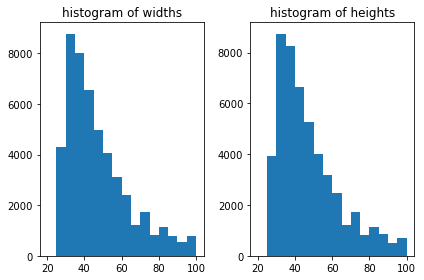

In [39]:
subplot(1, 2, 1)
hist(widths, bins = [20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]) 
title("histogram of widths")

subplot(1, 2, 2)
hist(heights, bins = [20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]) 
title("histogram of heights")

tight_layout()
show()

The similar structure of both of these plots tells us that images are square shaped, i.e, ~same width and height. So we can assume whatever we reshape our image into would be a square image

Now, as we can see, the majority of the images lie in the 35-40 basket, followed by 40-45. So, resizing images to 40x40 should be cast a wide net for all the images we want to train on.

Sounds well and good, and it looks like we can now move on but if you look at the numbers, there is a sizeable amount of pictures of size > 60, so downscaling them all could mean a significant loss in information.

(array([   0, 4291, 8785, 8024, 6536, 4970, 4057, 3120, 9450]), array([ 20,  25,  30,  35,  40,  45,  50,  55,  60, 100]))


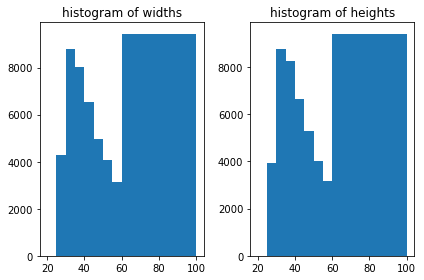

In [45]:
subplot(1, 2, 1)
hist(widths, bins = [20,25,30,35,40,45,50,55,60,100]) 
title("histogram of widths")

subplot(1, 2, 2)
hist(heights, bins = [20,25,30,35,40,45,50,55,60,100]) 
title("histogram of heights")

tight_layout()
show()

As you can see, there are more than 9000 images in the 60-100 range, so downsizing them all could definitely be a bad thing.

Also, choosing a value in the middle like 50x50 could be suboptimal because we are upscaling as well as downscaling, which again may or may not be a bad thing.

So one obvious approach that comes to my mind is to train the model with multiple input sizes.

But this is not as straightforward as PyTorch networks expect the inputs to be of a uniform size to any layer.

Hence, after a lot of digging in the PyTorch codebase and after asking 100s of questions in the Pytorch forums, I found this in Section 2.3 of this paper https://arxiv.org/pdf/1406.4729.pdf and a subsequent implementation of AdaptiveAvgPooling in PyTorch

Therefore, as discussed in more detail in The other notebook, I propose an 'Adaptive MultiScale CNN for Image Classification'.

On which, I will train images of size 32x32, 50x50 and 70x70

### Ablation study for augmentations:

Here I'll show images for every possible augmentation. I'll be trying out many argument values and plotting images but as you might imagine this notebook will only have the final ones which will be best after trying out a few. We remove the normalization to make it look okay while plotting.

Rotation:

In [6]:
training_transforms = transforms.Compose([
    transforms.Resize((50,50)),
    transforms.RandomRotation(20),
    transforms.ToTensor()
])

In [7]:
train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder('images/train_images',
                         transform=training_transforms),
    batch_size=4, shuffle=True, num_workers = 8)

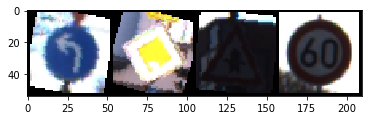

In [9]:
inputs, classes = next(iter(train_loader))
out = torchvision.utils.make_grid(inputs)

show(out)

#### A 20 degree rotation seems fine

#### RandomResizedCrop next

In [150]:
training_transforms = transforms.Compose([
    transforms.Resize((50,50)),
    transforms.RandomResizedCrop(size=32),
    transforms.ToTensor()
])

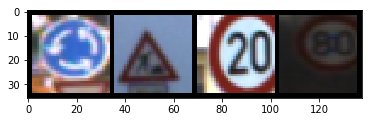

In [151]:
train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder('images/train_images',
                         transform=training_transforms),
    batch_size=4, shuffle=True, num_workers = 8)
inputs, classes = next(iter(train_loader))
out = torchvision.utils.make_grid(inputs)

show(out)

#### Trying translation next:

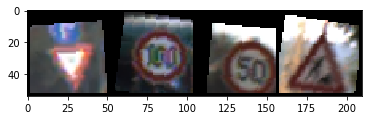

In [156]:
training_transforms = transforms.Compose([
    transforms.Resize((50,50)),
    transforms.RandomAffine(degrees=10, translate=(0.2,0.2)),
    transforms.ToTensor()
])

train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder('images/train_images',
                         transform=training_transforms),
    batch_size=4, shuffle=True, num_workers = 8)
inputs, classes = next(iter(train_loader))
out = torchvision.utils.make_grid(inputs)

show(out)

#### Shearing

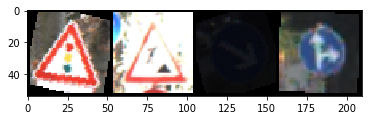

In [166]:
training_transforms = transforms.Compose([
    transforms.Resize((50,50)),
    transforms.RandomAffine(degrees=20, shear=3),
    transforms.ToTensor()
])

train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder('images/train_images',
                         transform=training_transforms),
    batch_size=4, shuffle=True, num_workers = 8)
inputs, classes = next(iter(train_loader))
out = torchvision.utils.make_grid(inputs)

show(out)

#### Brightness

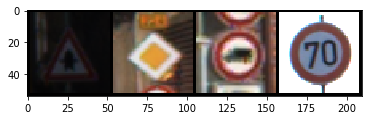

In [173]:
training_transforms = transforms.Compose([
    transforms.Resize((50,50)),
    transforms.ColorJitter(brightness=2.5),
    transforms.ToTensor()
])

train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder('images/train_images',
                         transform=training_transforms),
    batch_size=4, shuffle=True, num_workers = 8)
inputs, classes = next(iter(train_loader))
out = torchvision.utils.make_grid(inputs)

show(out)

#### Contrast

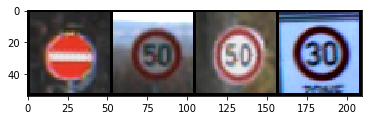

In [179]:
training_transforms = transforms.Compose([
    transforms.Resize((50,50)),
    transforms.ColorJitter(contrast=1.5),
    transforms.ToTensor()
])

train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder('images/train_images',
                         transform=training_transforms),
    batch_size=4, shuffle=True, num_workers = 8)
inputs, classes = next(iter(train_loader))
out = torchvision.utils.make_grid(inputs)

show(out)

### Saturation

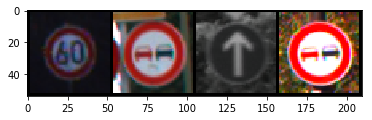

In [188]:
training_transforms = transforms.Compose([
    transforms.Resize((50,50)),
    transforms.ColorJitter(saturation=2),
    transforms.ToTensor()
])

train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder('images/train_images',
                         transform=training_transforms),
    batch_size=4, shuffle=True, num_workers = 8)
inputs, classes = next(iter(train_loader))
out = torchvision.utils.make_grid(inputs)

show(out)

#### Hue

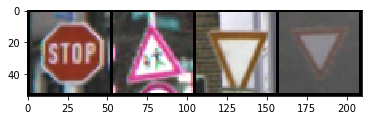

In [195]:
training_transforms = transforms.Compose([
    transforms.Resize((50,50)),
    transforms.ColorJitter(hue=0.2),
    transforms.ToTensor()
])

train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder('images/train_images',
                         transform=training_transforms),
    batch_size=4, shuffle=True, num_workers = 8)
inputs, classes = next(iter(train_loader))
out = torchvision.utils.make_grid(inputs)

show(out)

#### I am not choosing to do vertical flip, because I feel it could change the meaning of what a sign is saying.

#### Putting them all together:

/home/rm5310/pyenv/py3.6.3/lib/python3.6/site-packages/torchvision/transforms/functional.py:440: UserWarning: torch.gels is deprecated in favour of torch.lstsq and will be removed in the next release. Please use torch.lstsq instead.
  res = torch.gels(B, A)[0]
/home/rm5310/pyenv/py3.6.3/lib/python3.6/site-packages/torchvision/transforms/functional.py:440: UserWarning: torch.gels is deprecated in favour of torch.lstsq and will be removed in the next release. Please use torch.lstsq instead.
  res = torch.gels(B, A)[0]
/home/rm5310/pyenv/py3.6.3/lib/python3.6/site-packages/torchvision/transforms/functional.py:440: UserWarning: torch.gels is deprecated in favour of torch.lstsq and will be removed in the next release. Please use torch.lstsq instead.
  res = torch.gels(B, A)[0]
/home/rm5310/pyenv/py3.6.3/lib/python3.6/site-packages/torchvision/transforms/functional.py:440: UserWarning: torch.gels is deprecated in favour of torch.lstsq and will be removed in the next release. Please use torch

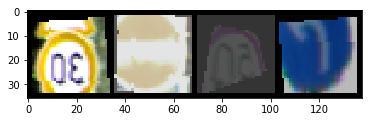

In [218]:
training_transforms = transforms.Compose([
    transforms.Resize((50,50)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(7),
    transforms.RandomResizedCrop(size=32),
    transforms.RandomAffine(degrees=5, translate=(0.07,0.07)),
    transforms.RandomAffine(degrees=5, shear=1.5),
    transforms.RandomPerspective(),
    transforms.ColorJitter(brightness=1),
    transforms.ColorJitter(contrast=1.2),
    transforms.ColorJitter(saturation=1),
    transforms.ColorJitter(hue=0.2),
    transforms.ToTensor()
])

train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder('images/train_images',
                         transform=training_transforms),
    batch_size=4, shuffle=True, num_workers = 8)
inputs, classes = next(iter(train_loader))
out = torchvision.utils.make_grid(inputs)

show(out)

These are all jumbled together and don't really seem that coherent. 

This is not what we want.

What we want is at one time, just one or two transforms being applied. So we'll have to change things up a bit.

We'll split up the transforms, and apply each one individually and concatenate the resulting transforms into our dataloader.

In [23]:
t0 = transforms.Compose([
    transforms.Resize((50, 50)),
    transforms.ToTensor()
])

t1 = transforms.Compose([
    transforms.Resize((50, 50)),
    transforms.ColorJitter(brightness=2.5),
    transforms.ToTensor()
])

t2 = transforms.Compose([
    transforms.Resize((50, 50)),
    transforms.ColorJitter(saturation=2),
    transforms.ToTensor()
])

t3 = transforms.Compose([
    transforms.Resize((50, 50)),
    transforms.ColorJitter(contrast=1.5),
    transforms.ToTensor()
])

t4 = transforms.Compose([
    transforms.Resize((50, 50)),
    transforms.ColorJitter(hue=0.2),
    transforms.ToTensor()
])

t5 = transforms.Compose([
    transforms.Resize((50, 50)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

t6 = transforms.Compose([
    transforms.Resize((50, 50)),
    transforms.RandomAffine(degrees=20, shear=3),
    transforms.ToTensor()
])

t7 = transforms.Compose([
    transforms.Resize((50, 50)),
    transforms.RandomAffine(degrees=10, translate=(0.2,0.2)),
    transforms.ToTensor()
])

t8 = transforms.Compose([
    transforms.Resize((50, 50)),
    transforms.RandomPerspective(),
    transforms.ToTensor()
])

t9 = transforms.Compose([
    transforms.Resize((50, 50)),
    transforms.RandomRotation(20),
    transforms.ToTensor()
])

t10 = transforms.Compose([
    transforms.Resize((75, 75)),
    transforms.RandomResizedCrop(size=50),
    transforms.ToTensor()
])

In [24]:
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.ConcatDataset([
        datasets.ImageFolder('images/train_images', transform=t0),
        datasets.ImageFolder('images/train_images', transform=t1),
        datasets.ImageFolder('images/train_images', transform=t2),
        datasets.ImageFolder('images/train_images', transform=t3),
        datasets.ImageFolder('images/train_images', transform=t4),
        datasets.ImageFolder('images/train_images', transform=t5),
        datasets.ImageFolder('images/train_images', transform=t6),
        datasets.ImageFolder('images/train_images', transform=t7),
        datasets.ImageFolder('images/train_images', transform=t8),
        datasets.ImageFolder('images/train_images', transform=t9),
    ]),
    batch_size=4, shuffle=True, num_workers = 8)

val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder('images/val_images', transform=test_transforms),
    batch_size=512, shuffle=False, num_workers = 8)

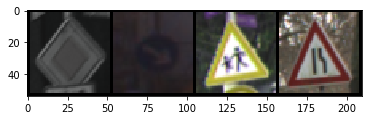

In [27]:
inputs, classes = next(iter(train_loader))
out = torchvision.utils.make_grid(inputs)

show(out)

Now these are much more coherent and what we'll use in our training pipeline.